In [125]:
from collections import Counter, defaultdict
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import importlib
import community as community_louvain
import time
import csv
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

import seaborn as sns

from Project.utils.objects import youtube
from Project.utils.storage import youtube_db as db
from Project.utils.analysis import text_classifier as tc

importlib.reload(tc)
importlib.reload(db)
importlib.reload(youtube)

<module 'Project.utils.objects.youtube' from 'C:\\Users\\Filippo Corti\\Documents\\GitHub\\SocialMediaMining\\Project\\utils\\objects\\youtube.py'>

In [30]:
trump_podcasts = [
    "xrFdHO7FH8w",
    "blqIZGXWUpU",
    "s11uIW7wi-E",
    "vC5cHjcgt5g",
    "G80iLTctFuY",
    "qCbfTN-caFI",
    "Ry1IjOft95c",
    "S7BTdUaNQM8",
    "1SsmPh8gCxU",
    "-dmwG54QsKc",
    "nwQil7tcImI",
    "G9lXnwuZ2qs",
    "hBMoPUAeLnY"
]

harris_podcasts = [
    "_KCRsjPCiCI",
    "bzThwqnQJDY",
    "7L4sts7I3xI",
    "pNbwMrBMGgE",
    "Vu5yD3fu6A8",
]

youtube_db = db.SQLiteYoutubeSaver()

text_classifier = tc.TextClassifier()

In [31]:
Youtube_Graph = youtube_db.extract_network()

# Add podcast_guest attribute
for node, data in Youtube_Graph.nodes(data=True):
    video_id = data.get('most_commented_video_id')
    if video_id in trump_podcasts:
        Youtube_Graph.nodes[node]['podcast_guest'] = 'Trump'
    else:
        Youtube_Graph.nodes[node]['podcast_guest'] = 'Harris'

#nx.write_gexf(Youtube_Graph, "youtube.gexf")


In [32]:
partition = community_louvain.best_partition(
    Youtube_Graph.to_undirected(),
    resolution=0.4
)

nx.set_node_attributes(Youtube_Graph, partition, 'community')

In [33]:
num_communities = len(set(partition.values()))

num_communities

443

In [35]:
nx.write_gexf(Youtube_Graph, "youtube.gexf")

In [36]:
Youtube_Graph = nx.read_gexf("youtube.gexf")

In [37]:
def gini_coeff(x):
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def analyze_graph(G, color):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    degree_values = list(degree.values())
    in_degree_values = list(in_degree.values())
    out_degree_values = list(out_degree.values())

    # Calculate Lorenz Curve for the Distribution of Posts between Users
    posts_count_dict = np.sort([
        node['comments_count']
        for node_id, node in G.nodes(data=True)
    ])
    posts_count_cdf = np.cumsum(posts_count_dict) / sum(posts_count_dict)
    lam = nx.density(G) * (G.order() - 1)
    poisson_posts_count = np.sort(np.random.poisson(lam=lam, size=len(posts_count_dict)))
    poisson_posts_count_cdf = np.cumsum(poisson_posts_count) / sum(poisson_posts_count)


    count, bins = np.histogram(
        in_degree_values,
        bins=np.arange(0, max(in_degree_values) + 2)
    )
    pdf = count / G.order()
    ccdf = 1.0 - np.cumsum(pdf)

    ccdf[-1] = 0.0 # Fixes floating point error

    print(f"Nodes with in degree zero: {len([x for x in in_degree_values if x == 0])}")

    # Compute connected component sizes
    cc = list(nx.weakly_connected_components(G))
    component_sizes = sorted([len(c) for c in cc], reverse=True)
    components_by_size = Counter(component_sizes)

    # Print stats
    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values):.2f}")
    print(f"Average In-Degree: {np.mean(in_degree_values):.2f}")
    print(f"Average Out-Degree: {np.mean(out_degree_values):.2f}")

    print(f"There are {len(cc)} Connected Components:")
    for component in cc[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)} ({len(component)/G.order():.2%})")
    print("\t...")

    top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by In-Degree:")
    for node, deg in top_in:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: In-Degree = {deg}")

    top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Out-Degree:")
    for node, deg in top_out:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Out-Degree = {deg}")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    top_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Degree Centrality:")
    for node, centrality in top_deg_centrality:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Degree Centrality = {centrality:.4f}")


    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], pdf, marker='o', linestyle='--', label="Degree PDF", color=color)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.title("In-Degree PDF")
    plt.xlabel("Degree")
    plt.ylabel("PDF - P(X=x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-2], ccdf[:-1], marker='o', linestyle='--', label="Degree CCDF", color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("In-Degree CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF - P(X>x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(posts_count_cdf)) / (len(posts_count_dict) - 1), posts_count_cdf, marker='o', linestyle='--', label="Network", color=color)
    plt.scatter(np.arange(len(poisson_posts_count_cdf)) / (len(poisson_posts_count) - 1), poisson_posts_count_cdf, marker='o', linestyle='--', label="Erdos-Renyi Random Network", color="gray")
    plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
    plt.title("Lorenz Curve of Posts per User")
    plt.xlabel("Cum. % of Users")
    plt.ylabel("Cum. % of Posts")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Gini Coefficient: {gini_coeff(posts_count_dict):.5f}")

    plt.figure(figsize=(7, 4))
    plt.scatter(list(components_by_size.keys()), list(components_by_size.values()), color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Weakly Connected Components")
    plt.xlabel("Component Size")
    plt.ylabel("# of Components")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(list(deg_centrality.values()), bins=50, log=True, color=color, alpha=0.7)
    plt.title("Distribuzione Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


58300 Nodes and 97531 Edges
Density is 2.8695448497788227e-05
Nodes with in degree zero: 42179
Min Degree: 1
Max Degree: 691
Average Degree: 3.35
Average In-Degree: 1.67
Average Out-Degree: 1.67
There are 361 Connected Components:
	Connected Component of size: 57278 (98.25%)
	Connected Component of size: 2 (0.00%)
	Connected Component of size: 4 (0.01%)
	...
Top 3 Nodes by In-Degree:
	Node @n2t http://www.youtube.com/@n2t: In-Degree = 691
	Node @huracanian3051 http://www.youtube.com/@huracanian3051: In-Degree = 689
	Node @DisskkonnectxX http://www.youtube.com/@DisskkonnectxX: In-Degree = 682
Top 3 Nodes by Out-Degree:
	Node @H-Town25 http://www.youtube.com/@H-Town25: Out-Degree = 95
	Node @BoolyK http://www.youtube.com/@BoolyK: Out-Degree = 78
	Node @daveonmasolino3336 http://www.youtube.com/@daveonmasolino3336: Out-Degree = 75
Top 3 Nodes by Degree Centrality:
	Node @n2t http://www.youtube.com/@n2t: Degree Centrality = 0.0119
	Node @huracanian3051 http://www.youtube.com/@huracanian305

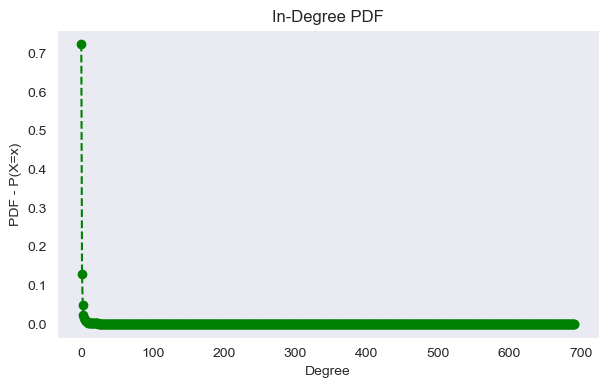

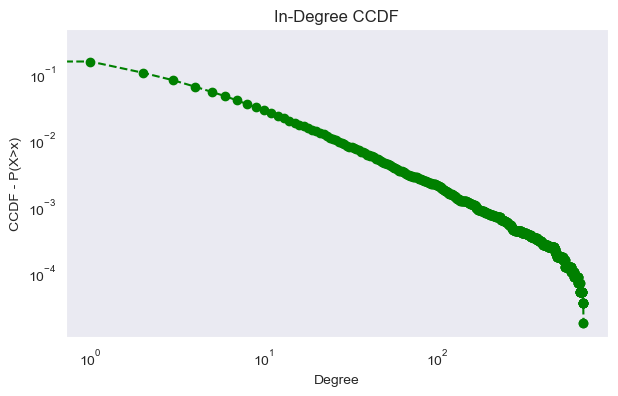

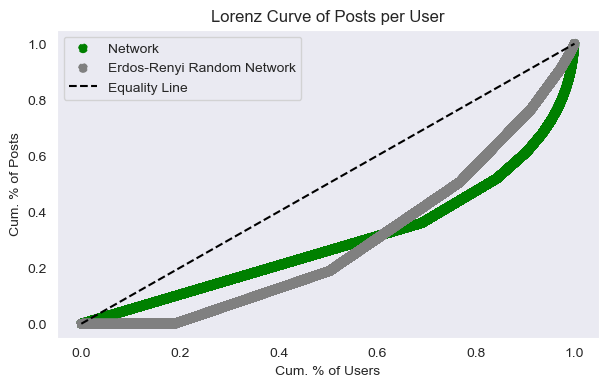

Gini Coefficient: 0.40516


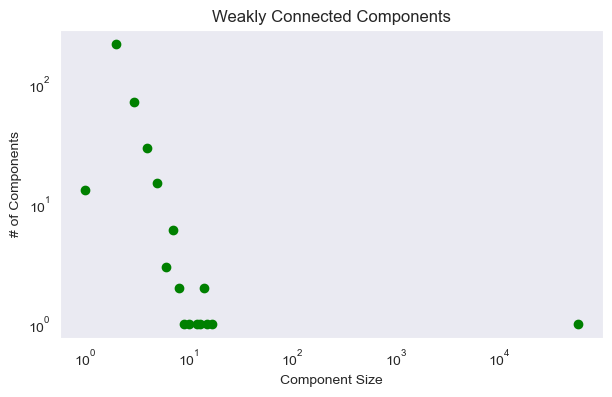

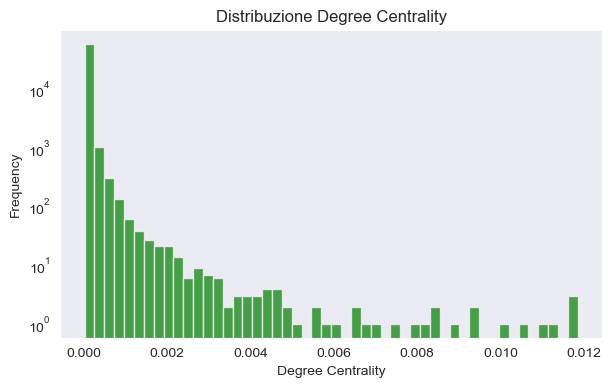

In [38]:
analyze_graph(Youtube_Graph, color="green")

In [39]:
yt_threads = youtube_db.get_threads()

thread_sizes = sorted([t.get_size() for t in yt_threads], reverse=True)
thread_unique_users = sorted([t.get_unique_users() for t in yt_threads], reverse=True)
thread_depths = sorted([t.get_depth() for t in yt_threads], reverse=True)
thread_wieners = sorted([t.get_wiener_index() for t in yt_threads], reverse=True)
thread_cpu = sorted([t.get_comments_per_user() for t in yt_threads], reverse=True)

print(len(yt_threads))
print(thread_sizes[:10])
print(thread_unique_users[:10])
print(thread_depths[:10])
print(thread_wieners[:10])
print(thread_cpu[:10])

7200
[787, 777, 777, 762, 757, 755, 754, 754, 753, 753]
[731, 715, 697, 690, 660, 660, 614, 613, 611, 603]
[36, 29, 27, 25, 25, 21, 21, 19, 19, 18]
[1432108.0, 1352822.0, 1237826.0, 1224816.0, 1202126.0, 1076329.0, 1070698.0, 973331.0, 952244.0, 950082.0]
[8.0, 7.0, 4.75, 4.0, 4.0, 3.888888888888889, 3.75, 3.4705882352941178, 3.3333333333333335, 3.0]


In [40]:
user_stance = {
    node: attrs["average_stance"]
    for node, attrs in Youtube_Graph.nodes(data=True)
}

In [41]:
def is_user_republican(account_id : str) -> bool:
    return user_stance.get(account_id, 0) > 0

def is_user_democratic(account_id : str) -> bool:
    return user_stance.get(account_id, 0) < 0

In [42]:
authors = set(user_stance.keys())

d = 0
r = 0
n = 0

for author in authors:
    if is_user_republican(author):
        r+=1
    elif is_user_democratic(author):
        d+=1
    else:
        n+=1


print(f"Republican: {r}, Democratic: {d}, Neutral: {n}")

Republican: 24706, Democratic: 7500, Neutral: 26094


In [44]:
yt_threads = youtube_db.get_threads()

print(f"Youtube Threads: {len(yt_threads)}")

rep_threads = list()
dem_threads = list()
neutral_threads = list()

trump_threads = list()
harris_threads = list()

for thread in yt_threads:
    if is_user_republican(thread.value.author.id):
        rep_threads.append(thread)
    elif is_user_democratic(thread.value.author.id):
        dem_threads.append(thread)
    else:
        neutral_threads.append(thread)

    if thread.value.video_id in trump_podcasts:
        trump_threads.append(thread)
    else:
        harris_threads.append(thread)

trump_dem_threads = [thread for thread in trump_threads if thread in dem_threads]
trump_rep_threads = [thread for thread in trump_threads if thread in rep_threads]
harris_rep_threads = [thread for thread in harris_threads if thread in rep_threads]
harris_dem_threads = [thread for thread in harris_threads if thread in dem_threads]


print(f"Republican: {len(rep_threads)}, Democratic: {len(dem_threads)}, Neutral: {len(neutral_threads)}")
print(f"Trump: {len(trump_threads)}, Harris: {len(harris_threads)}")
print(f"Rep under Trump: {len(trump_rep_threads)}, Dem under Harris: {len(harris_dem_threads)}")
print(f"Dem under Trump: {len(trump_dem_threads)}, Rep under Harris: {len(harris_rep_threads)}")


Youtube Threads: 7200
Republican: 2635, Democratic: 520, Neutral: 4045
Trump: 5200, Harris: 2000
Rep under Trump: 1850, Dem under Harris: 145
Dem under Trump: 375, Rep under Harris: 785


In [45]:
rep_thread_sizes = sorted([t.get_size() for t in rep_threads], reverse=True)
rep_thread_unique_users = sorted([t.get_unique_users() for t in rep_threads], reverse=True)
rep_thread_depths = sorted([t.get_depth() for t in rep_threads], reverse=True)
rep_thread_wieners = sorted([t.get_wiener_index() for t in rep_threads], reverse=True)
rep_thread_cpu = sorted([t.get_comments_per_user() for t in rep_threads], reverse=True)

dem_thread_sizes = sorted([t.get_size() for t in dem_threads], reverse=True)
dem_thread_unique_users = sorted([t.get_unique_users() for t in dem_threads], reverse=True)
dem_thread_depths = sorted([t.get_depth() for t in dem_threads], reverse=True)
dem_thread_wieners = sorted([t.get_wiener_index() for t in dem_threads], reverse=True)
dem_thread_cpu = sorted([t.get_comments_per_user() for t in dem_threads], reverse=True)

trump_thread_sizes = sorted([t.get_size() for t in trump_threads], reverse=True)
trump_thread_unique_users = sorted([t.get_unique_users() for t in trump_threads], reverse=True)
trump_thread_depths = sorted([t.get_depth() for t in trump_threads], reverse=True)
trump_thread_wieners = sorted([t.get_wiener_index() for t in trump_threads], reverse=True)
trump_thread_cpu = sorted([t.get_comments_per_user() for t in trump_threads], reverse=True)

harris_thread_sizes = sorted([t.get_size() for t in harris_threads], reverse=True)
harris_thread_unique_users = sorted([t.get_unique_users() for t in harris_threads], reverse=True)
harris_thread_depths = sorted([t.get_depth() for t in harris_threads], reverse=True)
harris_thread_wieners = sorted([t.get_wiener_index() for t in harris_threads], reverse=True)
harris_thread_cpu = sorted([t.get_comments_per_user() for t in harris_threads], reverse=True)

trump_dem_thread_sizes = sorted([t.get_size() for t in trump_dem_threads], reverse=True)
trump_dem_thread_unique_users = sorted([t.get_unique_users() for t in trump_dem_threads], reverse=True)
trump_dem_thread_depths = sorted([t.get_depth() for t in trump_dem_threads], reverse=True)
trump_dem_thread_wieners = sorted([t.get_wiener_index() for t in trump_dem_threads], reverse=True)
trump_dem_thread_cpu = sorted([t.get_comments_per_user() for t in trump_dem_threads], reverse=True)

trump_rep_thread_sizes = sorted([t.get_size() for t in trump_rep_threads], reverse=True)
trump_rep_thread_unique_users = sorted([t.get_unique_users() for t in trump_rep_threads], reverse=True)
trump_rep_thread_depths = sorted([t.get_depth() for t in trump_rep_threads], reverse=True)
trump_rep_thread_wieners = sorted([t.get_wiener_index() for t in trump_rep_threads], reverse=True)
trump_rep_thread_cpu = sorted([t.get_comments_per_user() for t in trump_rep_threads], reverse=True)

harris_dem_thread_sizes = sorted([t.get_size() for t in harris_dem_threads], reverse=True)
harris_dem_thread_unique_users = sorted([t.get_unique_users() for t in harris_dem_threads], reverse=True)
harris_dem_thread_depths = sorted([t.get_depth() for t in harris_dem_threads], reverse=True)
harris_dem_thread_wieners = sorted([t.get_wiener_index() for t in harris_dem_threads], reverse=True)
harris_dem_thread_cpu = sorted([t.get_comments_per_user() for t in harris_dem_threads], reverse=True)

harris_rep_thread_sizes = sorted([t.get_size() for t in harris_rep_threads], reverse=True)
harris_rep_thread_unique_users = sorted([t.get_unique_users() for t in harris_rep_threads], reverse=True)
harris_rep_thread_depths = sorted([t.get_depth() for t in harris_rep_threads], reverse=True)
harris_rep_thread_wieners = sorted([t.get_wiener_index() for t in harris_rep_threads], reverse=True)
harris_rep_thread_cpu = sorted([t.get_comments_per_user() for t in harris_rep_threads], reverse=True)

In [46]:
def plot_pdf_ccdf(
        list1,
        list2,
        title='PDF & CCDF',
        label1='List 1',
        label2='List 2',
        bins=50,
        loglog=True
):
    """
    Plot the PDF and CCDF of two datasets.

    Args:
        list1 (list): First dataset.
        list2 (list): Second dataset.
        title (str): The title of the plot
        label1 (str): The label for the first dataset
        label2 (str): The label for the second dataset
        bins (int): Number of bins for the histogram.
        loglog (bool): If True, plots log-log scale.
    """
    datasets = [list1, list2]
    labels = [label1, label2]
    colors = ['blue', 'orange']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # --- PDF (Histogram)
    for data, label, color in zip(datasets, labels, colors):
        counts, bin_edges = np.histogram(data, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[0].plot(bin_centers, counts, marker='o', linestyle='-', label=label, color=color)

    axs[0].set_title(title)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Density")
    axs[0].legend()
    if loglog:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    # --- CCDF
    for data, label, color in zip(datasets, labels, colors):
        sorted_data = np.sort(data)
        ccdf = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        axs[1].plot(sorted_data, ccdf, marker='o', linestyle='-', label=label, color=color)

    axs[1].set_title(title)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("CCDF")
    axs[1].legend()
    if loglog:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

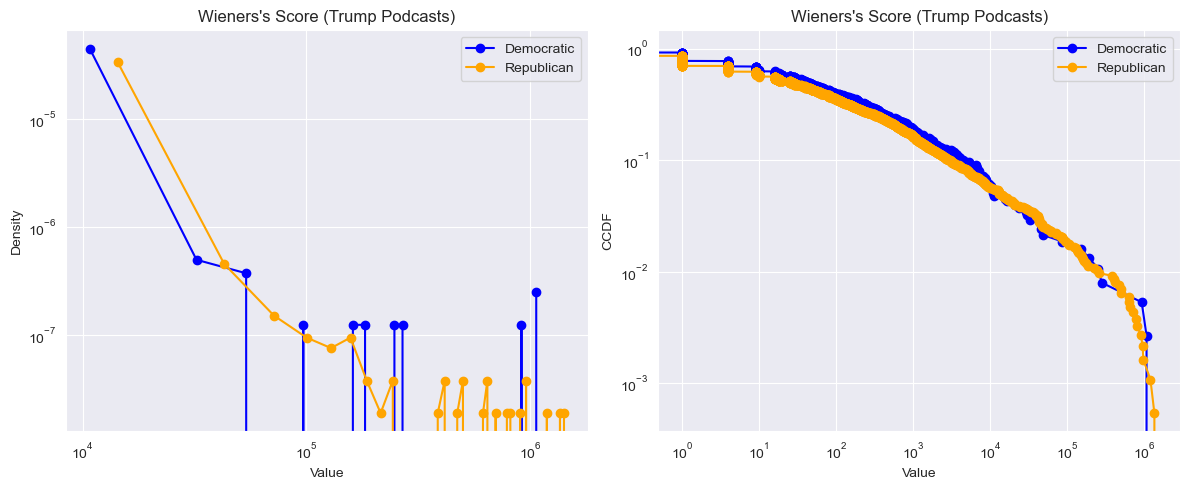

In [47]:
# Comparing the Wiener's Index Score in Trump Podcasts between Democratic Threads and Republican Threads
# A "Democratic Thread" is a Thread which has a Democratic root comment.

plot_pdf_ccdf(trump_dem_thread_wieners, trump_rep_thread_wieners, title="Wieners's Score (Trump Podcasts)", label1='Democratic', label2='Republican')

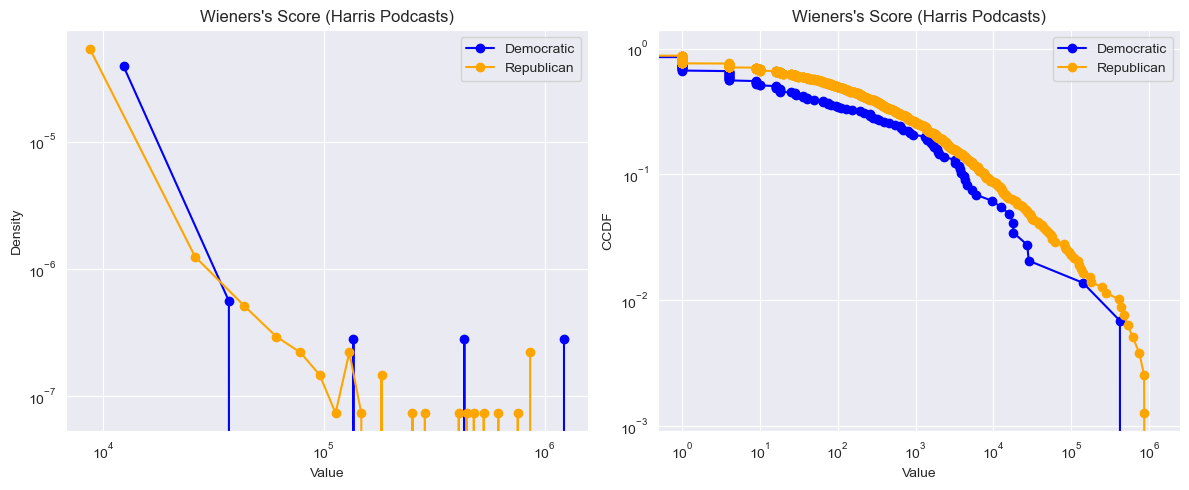

In [48]:
# Comparing the Wiener's Index Score in Harris Podcasts between Democratic Threads and Republican Threads

plot_pdf_ccdf(harris_dem_thread_wieners, harris_rep_thread_wieners, title="Wieners's Score (Harris Podcasts)", label1='Democratic', label2='Republican')

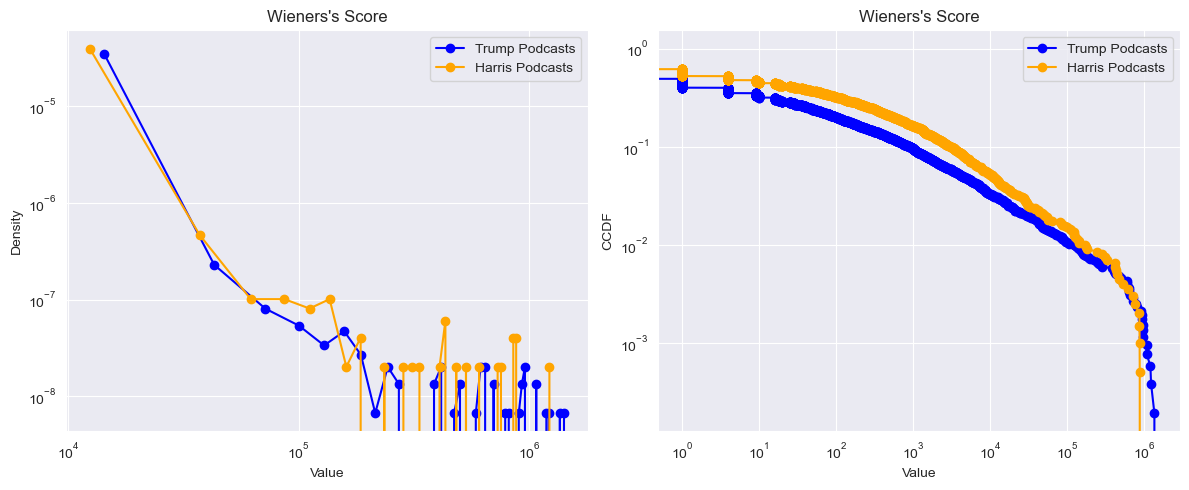

In [50]:
# Comparing the Wiener's Index Score between Trump and Harris Podcasts

plot_pdf_ccdf(trump_thread_wieners, harris_thread_wieners, title="Wieners's Score", label1='Trump Podcasts', label2='Harris Podcasts')

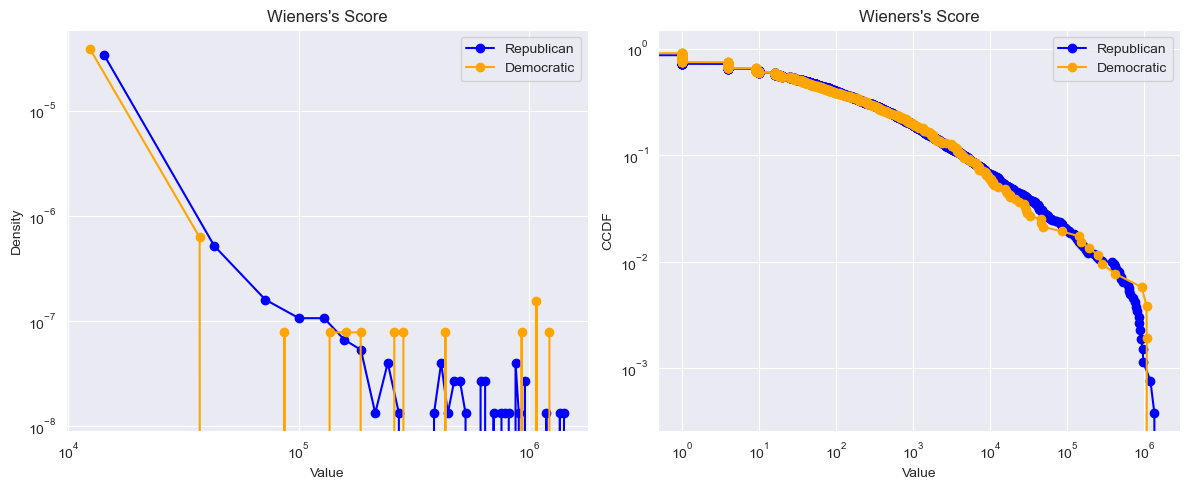

In [53]:
# Comparing the Wiener's Index Score between Republican and Democratic Threads

plot_pdf_ccdf(rep_thread_wieners, dem_thread_wieners, title="Wieners's Score", label1='Republican', label2='Democratic')

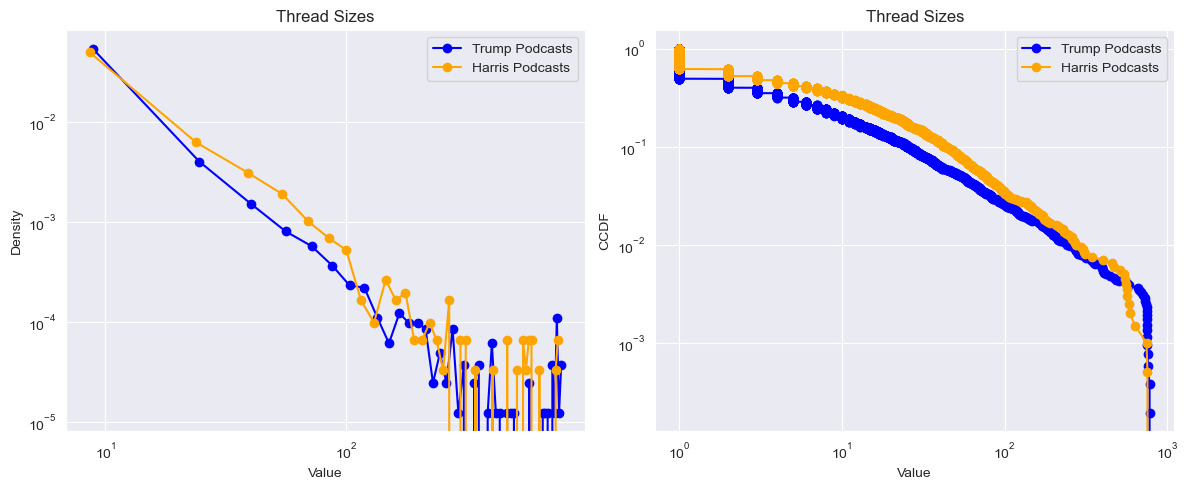

In [54]:
# Comparing the Size of the Threads between Trump and Harris Podcasts

plot_pdf_ccdf(trump_thread_sizes, harris_thread_sizes, title="Thread Sizes", label1='Trump Podcasts', label2='Harris Podcasts')

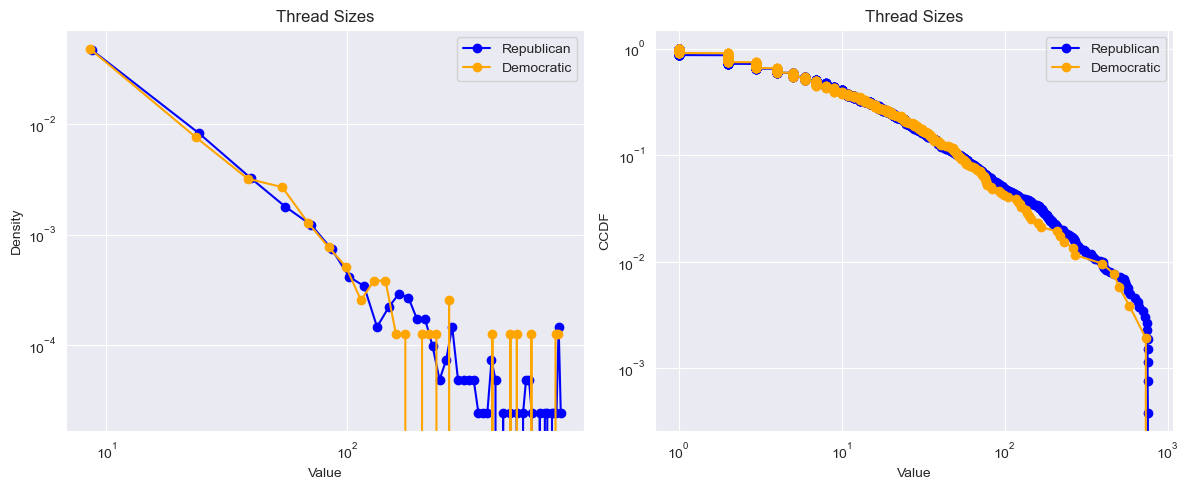

In [55]:
# Comparing the Size of the Threads between Republican and Democratic Threads

plot_pdf_ccdf(rep_thread_sizes, dem_thread_sizes, title="Thread Sizes", label1='Republican', label2='Democratic')

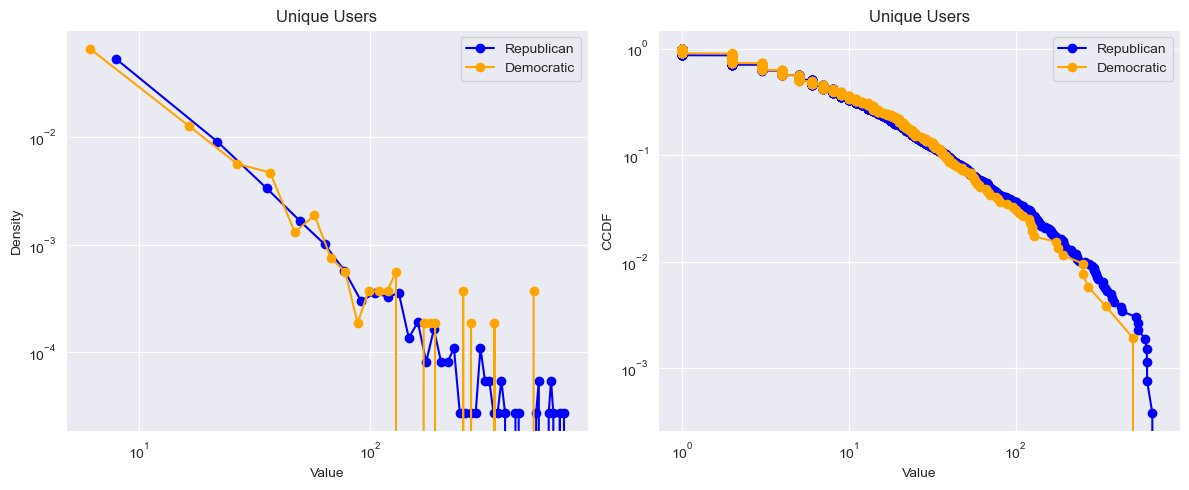

In [56]:
# Comparing the # of Unique Users involved in the Threads between Republican and Democratic Threads

plot_pdf_ccdf(rep_thread_unique_users, dem_thread_unique_users, title="Unique Users", label1='Republican', label2='Democratic')

In [57]:
def is_cross_partisan(branch : list[youtube.YTComment]) -> bool:
    if not branch: return False
    stances = [user_stance.get(comment.author.id, 0) for comment in branch]
    return any(s > 0 for s in stances) and any(s < 0 for s in stances) # At least on > 0 and one < 0

In [65]:
# Extract Branches from Threads

all_branches = [
    branch
    for thread in yt_threads
    for branch in thread.get_branches()
]

cross_partisan_branches = [
    branch
    for branch in all_branches
    if is_cross_partisan(branch)
]

print(f"Total Branches are {len(all_branches)}")
print(f"Total Comments are: {sum([len(branch) for branch in all_branches])}") # More than the original size because many are duplicated
print(f"Cross Partisan: {len(cross_partisan_branches)} ({len(cross_partisan_branches)/len(all_branches)*100:.2f}%)")

Total Branches are 90570
Total Comments are: 247904
Cross Partisan: 22657 (25.02%)


In [66]:
# Filter branches to analyze only a selection of them

filtered_branches = [
    branch
    for branch in all_branches
    if len(branch) >= 4
       and len(branch) / len(set([comment.author.id for comment in branch])) > 1.3
] # At least 4 comments, average of > 1.5 comment per user

filtered_cross_partisan_branches = [branch for branch in filtered_branches if is_cross_partisan(branch)]

filtered_non_cross_partisan_branches = [branch for branch in filtered_branches if not is_cross_partisan(branch)]

filtered_trump_branches = [branch for branch in filtered_branches if branch[0].video_id in trump_podcasts]

filtered_harris_branches = [branch for branch in filtered_branches if branch[0].video_id in harris_podcasts]

branch_by_id = {
    branch_id: branch
    for branch_id, branch in enumerate(filtered_branches)
}

print(f"Filtered: {len(filtered_branches)}")
print(f"Total Comments are now: {sum([len(branch) for branch in filtered_branches])}")
print(f"Cross Partisan Filtered: {len(filtered_cross_partisan_branches)}")
print(f"Non Cross Partisan Filtered: {len(filtered_non_cross_partisan_branches)}")
print(f"Trump Filtered: {len(filtered_trump_branches)}")
print(f"Harris Filtered: {len(filtered_harris_branches)}")

Filtered: 4627
Total Comments are now: 33925
Cross Partisan Filtered: 2821
Non Cross Partisan Filtered: 1806
Trump Filtered: 2833
Harris Filtered: 1794


In [67]:
branch = filtered_cross_partisan_branches[164]
for comment in branch:
    print(f"{comment.author.display_name}: {comment.content} ({user_stance.get(comment.author.id)})")

@ESPLTD322: Shadow banning WON’T stop us all voting on November 5th. MAGA 🇺🇸 (1.0)
@petershaw6346: If he didn't make it great the first time around he isn't going to do it if he gets back in (-0.1111111111111111)
@ashtonsmith1905: @@petershaw6346how old were u when trump was in office😂 12? (0.0)
@petershaw6346: @@ashtonsmith1905 what did Trump do for the American people? (-0.1111111111111111)
@FreeThinker0: @petershaw6346  at least things were stable while he was in the office. (0.5)
@petershaw6346: @@FreeThinker0 what was stable? (-0.1111111111111111)
@FreeThinker0: @@petershaw6346 a few of those are the prices for gas and goods, interest rate, and relationship with foreign countries. (0.5)
@petershaw6346: @@FreeThinker0 Putin's unjustifiable invasion of Ukraine is why everything is expensive that's why central banks in almost every country has raised interest rates (-0.1111111111111111)
@zblicky2573: @@petershaw6346 lol if you do your own research like most newer republicans do you c

In [68]:
branch = filtered_non_cross_partisan_branches[164]
for comment in branch:
    print(f"{comment.author.display_name}: {comment.content} ({user_stance.get(comment.author.id)})")

@bencharlie9509: The President now has an EV! He’s always said he’s not against EVs, he wants us to have a choice not be told we have to buy them. (1.0)
@diesel2464: Whats the meaning of EV ? (0.0)
@canadiangoose7665: @@diesel2464electric vehicle (0.0)
@diesel2464: @@canadiangoose7665 a scholar and a gentleman. Thanks (0.0)


In [40]:
# Now that numbers are reduced by a lot, we can:
# - Run Perspective API on each comment, for toxicity score
# - Run an LLM to extract:
#    1. Topics ("Summarize this conversation with 3–5 concise topic keywords or phrases.")
#    2. Outcome ("Did the conversation end in agreement, disagreement, or inconclusive?")

In [ ]:
# Get a Toxicity Score for each Branch (given by the average toxicity of its comments)

def get_branch_toxicity(branch : list[youtube.YTComment]) -> float:
    scores = list()
    for comment in branch:
        score = text_classifier.get_toxicity_score(comment.content)
        if score:
            scores.append(score)
        time.sleep(0.98) # Perspective API allows for 60 requests every minute
    if len(scores) == 0: return 0
    return sum(scores) / len(scores)

branch_toxicities = dict()

with open("branch_toxicities.csv", mode="a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    f.seek(0, 2)
    if f.tell() == 0:
        writer.writerow(["branch_id", "toxicity"])

    for idx, branch in branch_by_id.items():
        toxicity = get_branch_toxicity(branch)
        branch_toxicities[idx] = toxicity
        writer.writerow([idx, f"{toxicity:.4f}"])
        f.flush()

        print(f"{idx}/{len(branch_by_id)} - Toxicity is {toxicity:.2f}")

In [ ]:
def branch_to_string(branch : list[youtube.YTComment]) -> str:
    result = ""
    for comment in branch:
        result += f"{comment.author.display_name}: {comment.content}"
    return result

with open("branch_topics_ending.csv", mode="a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    f.seek(0, 2)
    if f.tell() == 0:
        writer.writerow(["branch_id", "topics", "ending"])

    for idx, branch in branch_by_id.items():
        json_response = text_classifier.get_gemini_discussion_analysis(branch_to_string(branch))
        topics = " - ".join(json_response["topics"])
        ending = json_response["ending"]
        writer.writerow([idx, topics, ending])
        f.flush()

        print(idx, json_response)

In [70]:
# Topics are very noisy - We can use Clustering to find around 10 relevant topics

df = pd.read_csv("branch_topics_ending.csv", sep=",")

# 1. Extract single topics from csv
df["topics"] = df["topics"].str.split(" - ")
df = df.explode("topics")
df["topics"] = df["topics"].str.strip()

In [72]:
# 2. Extract unique topics list
unique_topics = df["topics"].unique().tolist()

print(f"There are {len(unique_topics)} topics")

There are 6803 topics


In [73]:
# 3. Run text embedding for clustering
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(unique_topics)

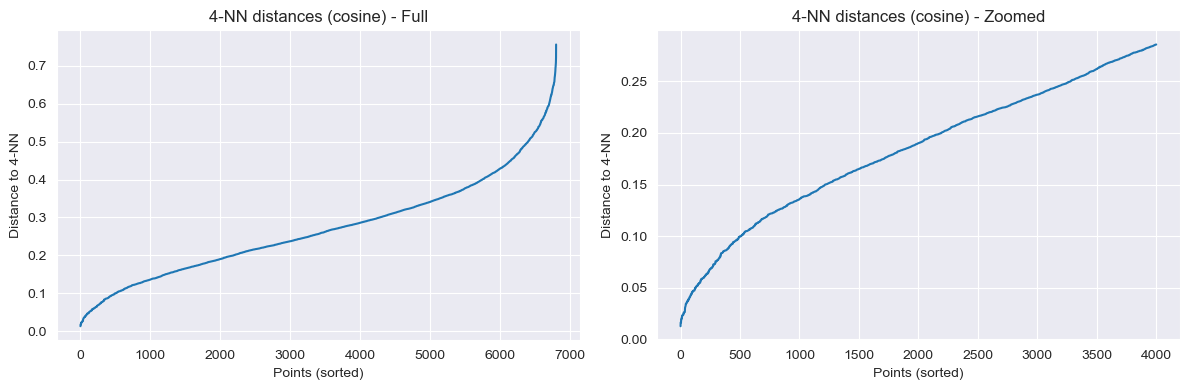

In [78]:
# Step 4: Find EPS value for DBSCAN
# DBSCAN is used compared to KMeans because of the ability to filter out noise with very little effort

min_samples = 4

neighbors = NearestNeighbors(n_neighbors=min_samples, metric='cosine')
neighbors_fit = neighbors.fit(embeddings)
distances, indices = neighbors_fit.kneighbors(embeddings)

# Get distance to the k-th nearest neighbor for each point
k_distances = np.sort(distances[:, -1])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Full range plot
axes[0].plot(k_distances)
axes[0].set_title(f"{min_samples}-NN distances (cosine) - Full")
axes[0].set_xlabel("Points (sorted)")
axes[0].set_ylabel(f"Distance to {min_samples}-NN")
axes[0].grid(True)

# Zoomed-in plot
axes[1].plot(k_distances[:4000])
axes[1].set_title(f"{min_samples}-NN distances (cosine) - Zoomed")
axes[1].set_xlabel("Points (sorted)")
axes[1].set_ylabel(f"Distance to {min_samples}-NN")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [79]:
# Step 5: Run DBSCAN for Clustering


eps = 0.1  # There's not a clear elbow, so probably really small
min_samples = 4

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
labels = dbscan.fit_predict(embeddings)

In [80]:
# Step 5: Map each original topic to macro cluster
topic_to_cluster = {
    topic: f"macro_topic_{label}" if label != -1 else "noise"
    for topic, label in zip(unique_topics, labels)
}
df["macro_topic"] = df["topics"].map(topic_to_cluster)

In [81]:
df

,branch_id,topics,ending,macro_topic
0,0,Trump support,disagreement,macro_topic_0
0,0,Media bypass,disagreement,noise
0,0,Popularity assessment,disagreement,noise
1,1,Media bias,inconclusive,macro_topic_1
1,1,Trump's communication,inconclusive,noise
...,...,...,...,...
4625,4625,criticism of Trump,inconclusive,macro_topic_19
4625,4625,comparison to Joe Rogan interview,inconclusive,macro_topic_7
4626,4626,dislike count,inconclusive,noise
4626,4626,YouTube extension,inconclusive,noise


In [85]:
Counter(df["macro_topic"])

Counter({'noise': 12253,
         'macro_topic_1': 459,
         'macro_topic_0': 190,
         'macro_topic_4': 137,
         'macro_topic_3': 123,
         'macro_topic_18': 107,
         'macro_topic_20': 96,
         'macro_topic_19': 95,
         'macro_topic_26': 95,
         'macro_topic_72': 74,
         'macro_topic_2': 70,
         'macro_topic_24': 57,
         'macro_topic_5': 51,
         'macro_topic_16': 50,
         'macro_topic_76': 50,
         'macro_topic_116': 49,
         'macro_topic_75': 44,
         'macro_topic_14': 43,
         'macro_topic_58': 42,
         'macro_topic_77': 42,
         'macro_topic_69': 39,
         'macro_topic_29': 38,
         'macro_topic_8': 36,
         'macro_topic_81': 36,
         'macro_topic_37': 35,
         'macro_topic_85': 35,
         'macro_topic_106': 30,
         'macro_topic_91': 29,
         'macro_topic_21': 28,
         'macro_topic_92': 25,
         'macro_topic_79': 24,
         'macro_topic_22': 23,
         'macr

In [87]:
# Manual small clustering for the largest topics

topics_names = {
    "macro_topic_1": "Media Bias",
    "macro_topic_5": "Interviews/Podcasts",
    "macro_topic_11": "Ukraine War",
    "macro_topic_24": "Tariffs and Economy",
    "macro_topic_20": "Trump",
    "macro_topic_69": "Harris",
    "macro_topic_18": "Cognitive Decline",
    "macro_topic_77": "2020 Elections Denial",
    "macro_topic_106": "Abortion Rights",
    "macro_topic_75": "Election Predictions",

    "macro_topic_0": "Trump",
    "macro_topic_3": "Trump",
    "macro_topic_15": "Trump",
    "macro_topic_19": "Trump",
    "macro_topic_76": "Harris",
    "macro_topic_116": "Harris",
    "macro_topic_92": "Harris",
    "macro_topic_4": "Interviews/Podcasts",
    "macro_topic_72": "Interviews/Podcasts",
    "macro_topic_81": "Interviews/Podcasts",
    "macro_topic_37": "Interviews/Podcasts",
    "macro_topic_85": "Interviews/Podcasts",
    "macro_topic_16": "Tariffs and Economy",
    "macro_topic_25": "Tariffs and Economy",
    "macro_topic_29": "Election Predictions",
}

df["macro_topic_name"] = df["macro_topic"].map(topics_names).fillna("Other")

In [93]:
df = df[["branch_id", "ending", "macro_topic_name"]].copy() # Filter out useless columns

In [94]:
# Now we can build a single DF and plot the statistics we care about

df_toxicities = pd.read_csv("branch_toxicities.csv", sep=",")

toxicities_map = {
    row[1]: row[2]
    for row in df_toxicities.itertuples()
}

df["toxicity"] = [toxicities_map[branch_id] for branch_id in df["branch_id"]]

df["stance"] = [user_stance.get(all_branches[branch_id][0].author.id, 0) for branch_id in df["branch_id"]]

df["cross_partisan"] = [is_cross_partisan(all_branches[branch_id]) for branch_id in df["branch_id"]]

In [114]:
#df.to_csv("branch_stats.csv", index=False)

df = pd.read_csv("branch_stats.csv", sep=",")


In [115]:
df

,branch_id,ending,macro_topic_name,toxicity,stance,cross_partisan
0,0,disagreement,Trump,0.0323,1.0,False
1,0,disagreement,Other,0.0323,1.0,False
2,0,disagreement,Other,0.0323,1.0,False
3,1,inconclusive,Media Bias,0.0600,1.0,False
4,1,inconclusive,Other,0.0600,1.0,False
...,...,...,...,...,...,...
15452,4625,inconclusive,Trump,0.1167,0.4,True
15453,4625,inconclusive,Other,0.1167,0.4,True
15454,4626,inconclusive,Other,0.0693,0.4,True
15455,4626,inconclusive,Other,0.0693,0.4,True


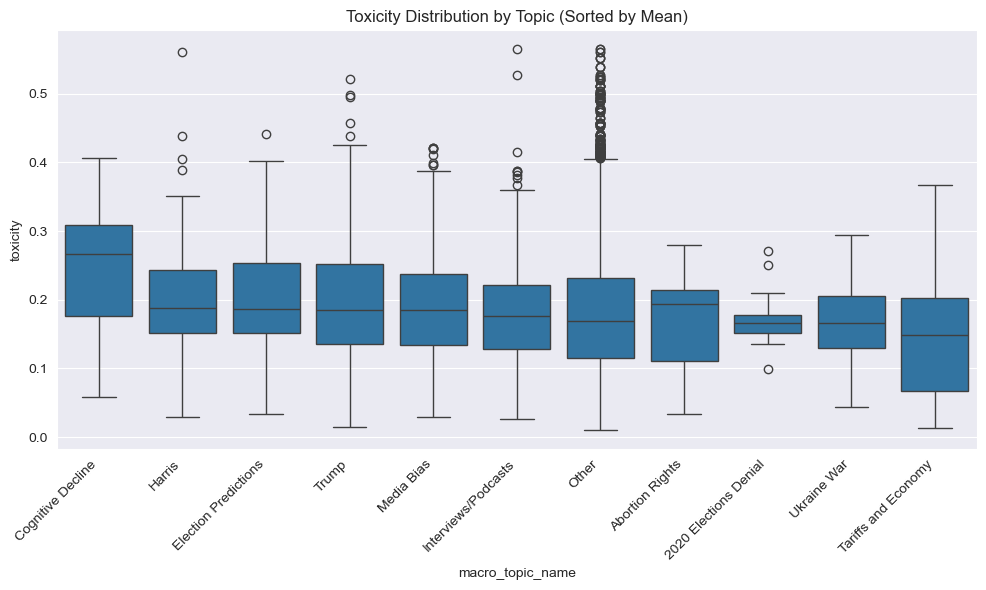

In [98]:
# Calculate mean toxicity per topic
mean_toxicity = df.groupby("macro_topic_name")["toxicity"].mean()

# Sort topics by mean toxicity
sorted_topics = mean_toxicity.sort_values(ascending=False).index

# Create boxplot with sorted topics
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="macro_topic_name", y="toxicity", order=sorted_topics)
plt.xticks(rotation=45, ha="right")
plt.title("Toxicity Distribution by Topic (Sorted by Mean)")
plt.tight_layout()
plt.show()

C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_8964\2584960654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="ending", y="stance", inner="box", palette="Set2")


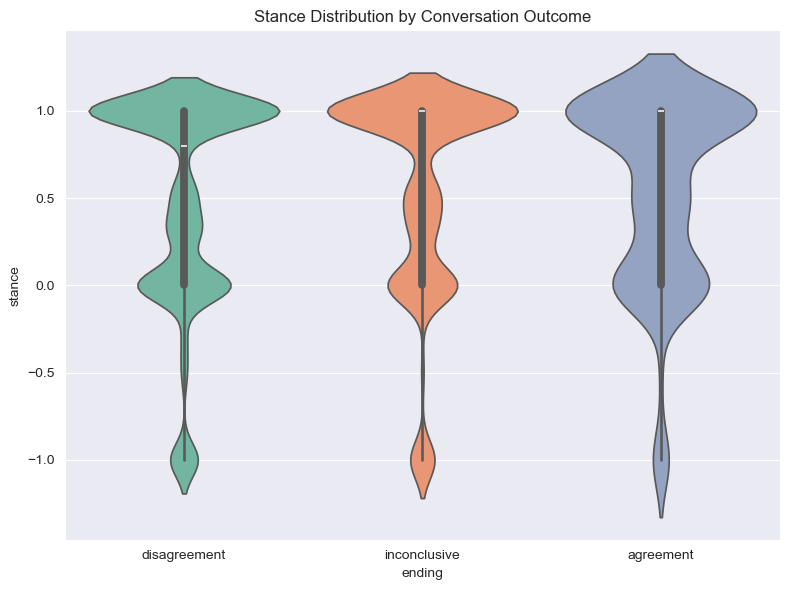

In [105]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="ending", y="stance", inner="box", palette="Set2")
plt.title("Stance Distribution by Conversation Outcome")
plt.tight_layout()
plt.show()

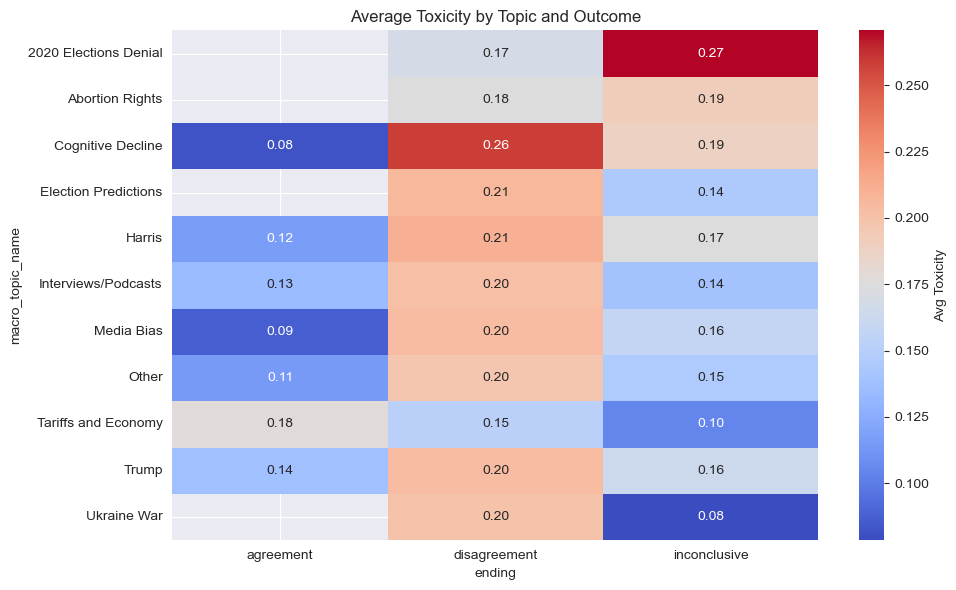

In [107]:
pivot = df.pivot_table(index="macro_topic_name", columns="ending", values="toxicity", aggfunc="mean")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Avg Toxicity"})
plt.title("Average Toxicity by Topic and Outcome")
plt.tight_layout()
plt.show()

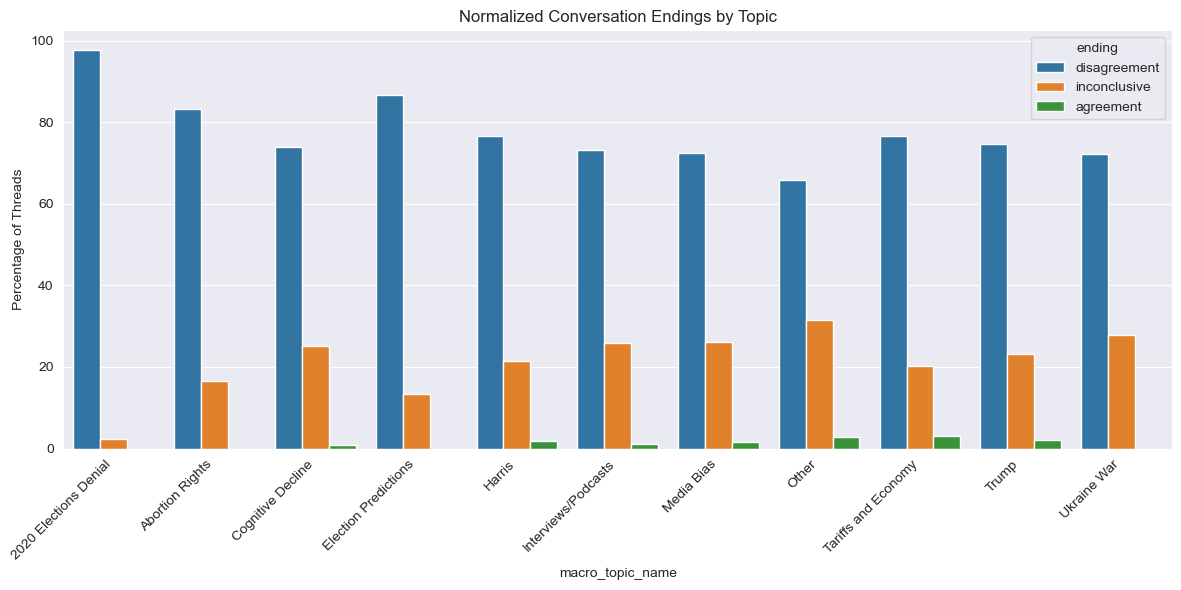

In [110]:
# Count total threads per topic + ending
counts = df.groupby(["macro_topic_name", "ending"]).size().reset_index(name="count")

# Normalize: compute % of each ending *within each topic*
total_per_topic = counts.groupby("macro_topic_name")["count"].transform("sum")
counts["percentage"] = counts["count"] / total_per_topic * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=counts, x="macro_topic_name", y="percentage", hue="ending")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentage of Threads")
plt.title("Normalized Conversation Endings by Topic")
plt.tight_layout()
plt.show()

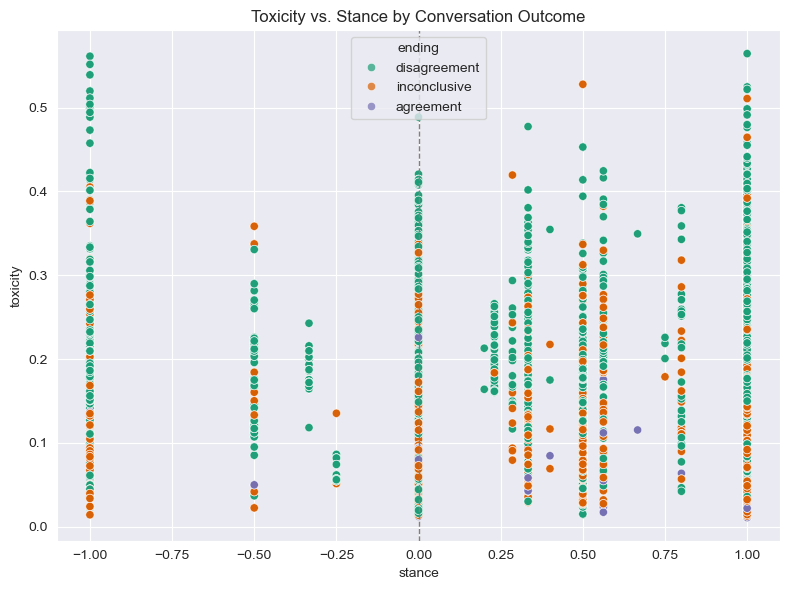

In [111]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="stance", y="toxicity", hue="ending", alpha=0.7, palette="Dark2")
plt.title("Toxicity vs. Stance by Conversation Outcome")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

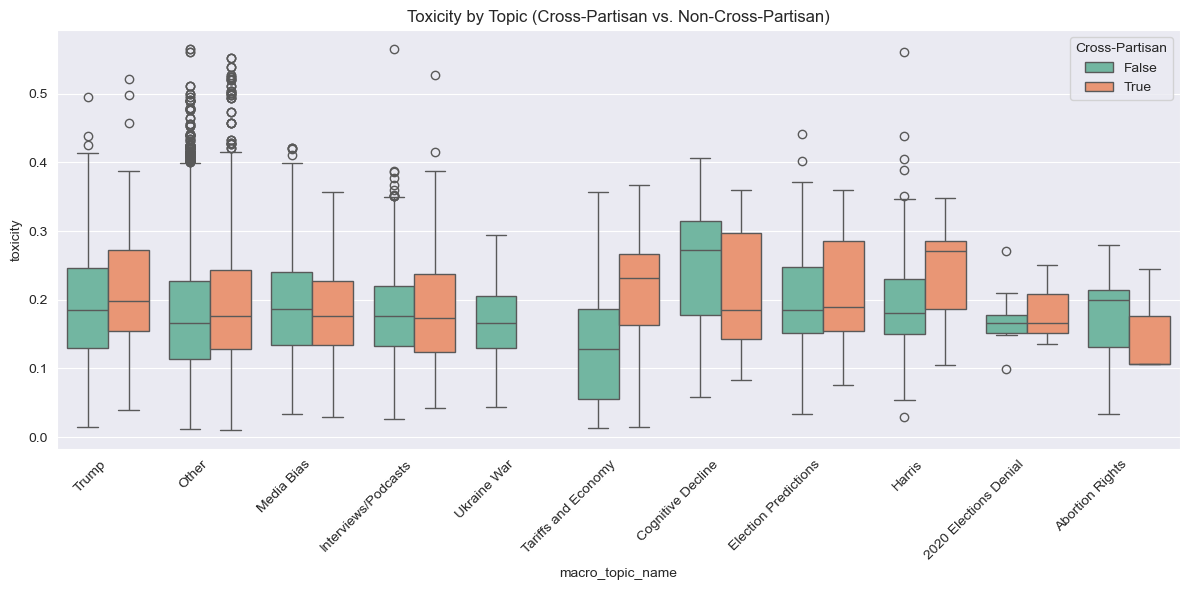

In [116]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="macro_topic_name",
    y="toxicity",
    hue="cross_partisan",
    palette="Set2"
)
plt.xticks(rotation=45, ha="right")
plt.title("Toxicity by Topic (Cross-Partisan vs. Non-Cross-Partisan)")
plt.legend(title="Cross-Partisan")
plt.tight_layout()
plt.show()

C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_8964\432098050.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


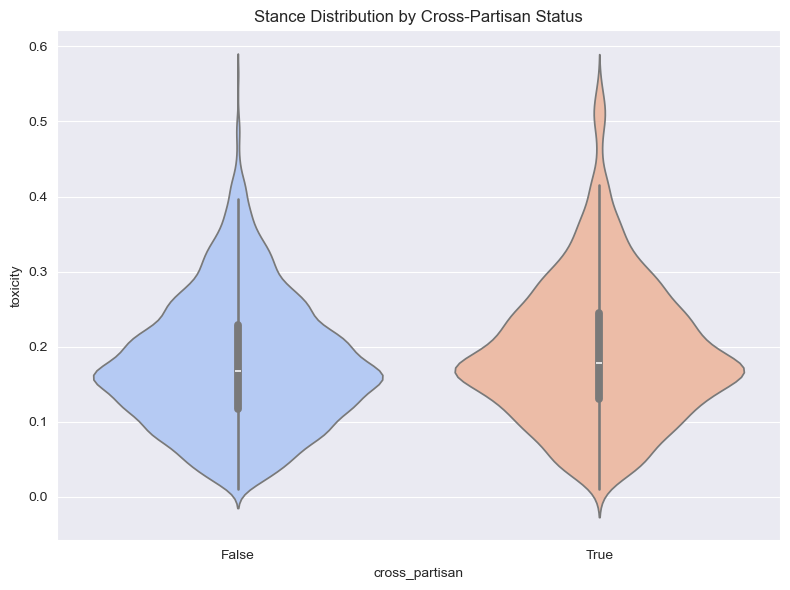

In [118]:
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df,
    x="cross_partisan",
    y="toxicity",
    inner="box",
    palette="coolwarm"
)
plt.title("Stance Distribution by Cross-Partisan Status")
plt.tight_layout()
plt.show()

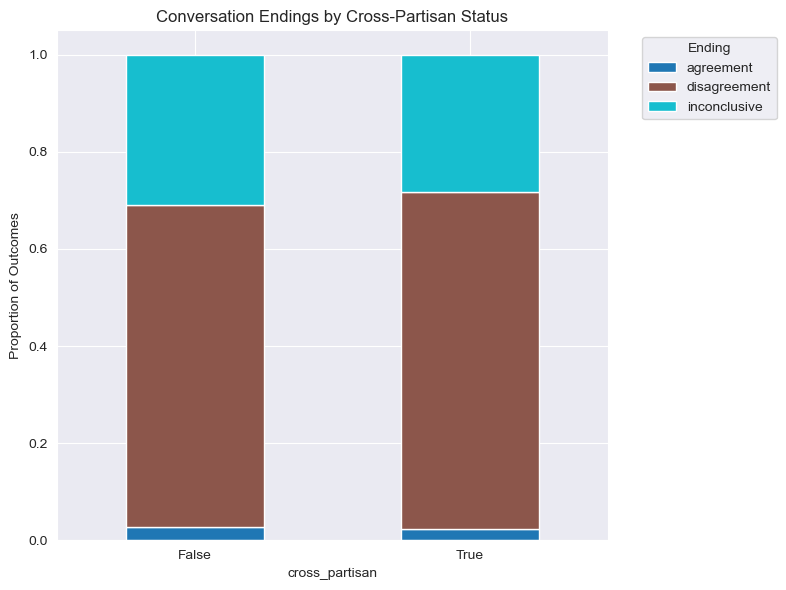

In [119]:
counts = df.groupby(["cross_partisan", "ending"]).size().unstack().fillna(0)
counts_percent = counts.div(counts.sum(axis=1), axis=0)  # Normalize to percentage

counts_percent.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="tab10")
plt.ylabel("Proportion of Outcomes")
plt.title("Conversation Endings by Cross-Partisan Status")
plt.xticks(rotation=0)
plt.legend(title="Ending", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

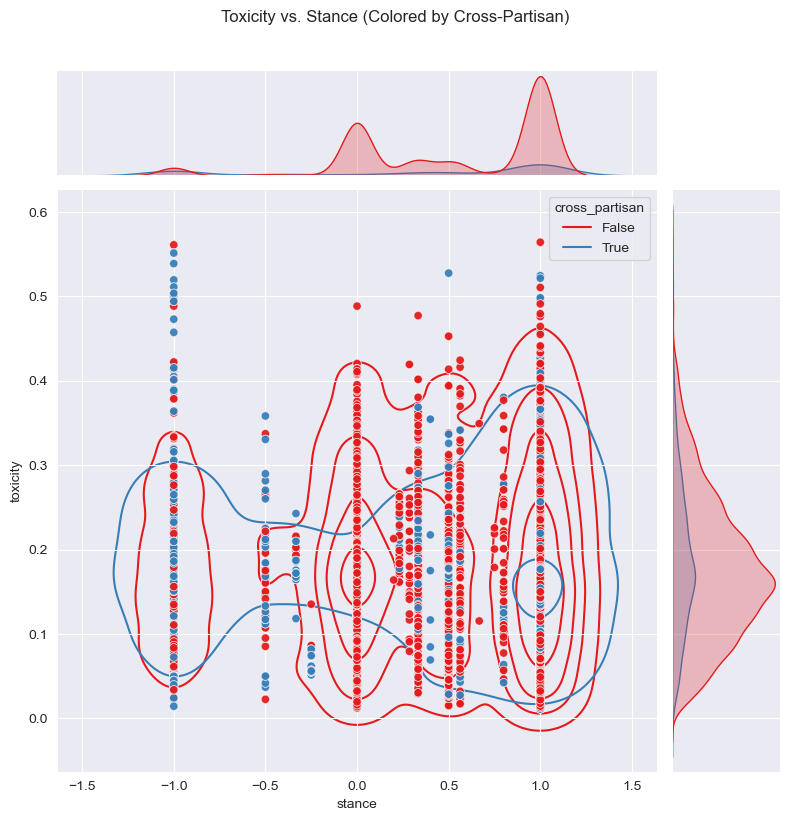

In [120]:
sns.jointplot(
    data=df,
    x="stance",
    y="toxicity",
    hue="cross_partisan",
    kind="scatter",
    palette="Set1",
    alpha=0.6,
    height=8
).plot_joint(sns.kdeplot, zorder=0, levels=5)
plt.suptitle("Toxicity vs. Stance (Colored by Cross-Partisan)", y=1.02)
plt.tight_layout()
plt.show()

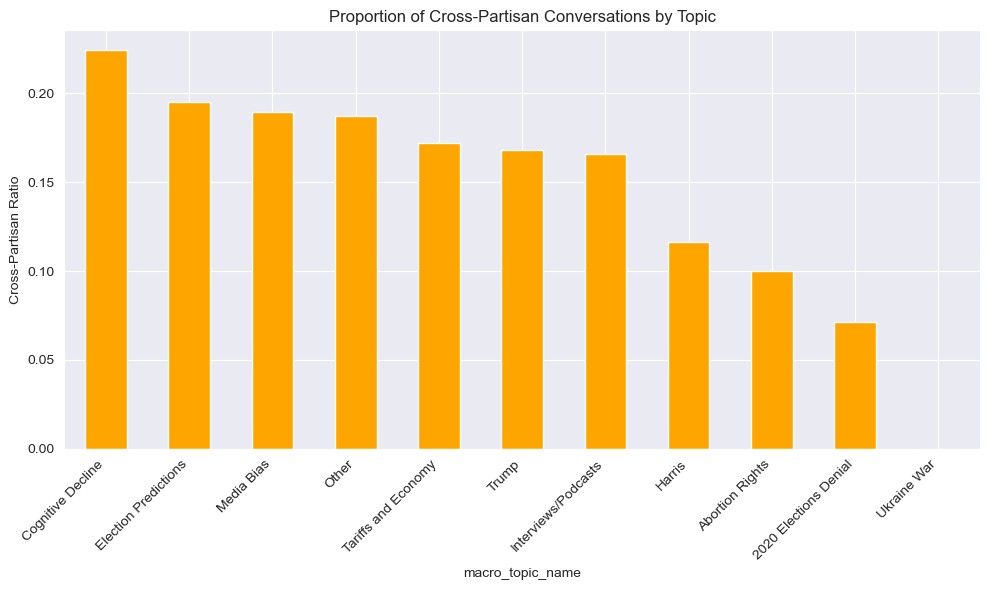

In [128]:
cross_counts = df.groupby("macro_topic_name")["cross_partisan"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
cross_counts.plot(kind="bar", color="orange")
plt.title("Proportion of Cross-Partisan Conversations by Topic")
plt.ylabel("Cross-Partisan Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

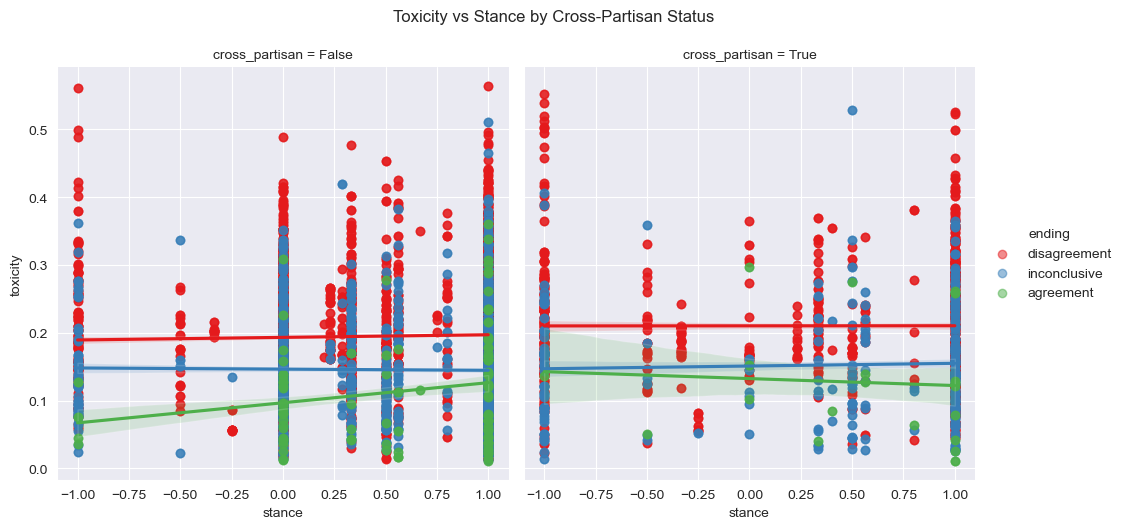

In [131]:
sns.lmplot(
    data=df,
    x="stance",
    y="toxicity",
    col="cross_partisan",
    hue="ending",  # Optional: color by agreement/disagreement
    palette="Set1",
    scatter_kws={'alpha':0.5},
    height=5,
    aspect=1
)
plt.suptitle("Toxicity vs Stance by Cross-Partisan Status", y=1.05)
plt.show()

C:\Users\Filippo Corti\AppData\Local\Temp\ipykernel_8964\3251251178.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_stats.index, rotation=45, ha="right")


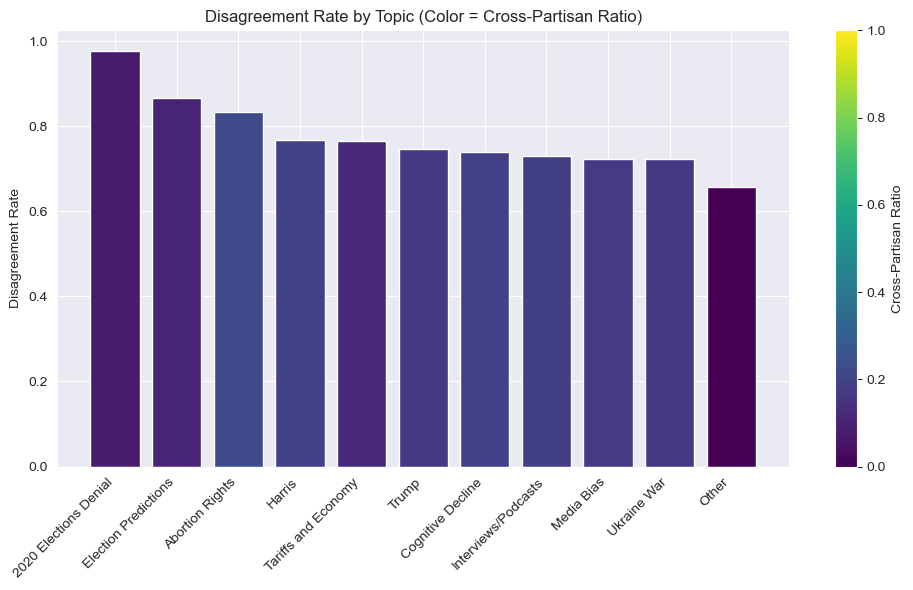

In [133]:
topic_stats = df.groupby("macro_topic_name").agg({
    "ending": lambda x: (x == "disagreement").mean(),
    "cross_partisan": "mean"
}).rename(columns={"ending": "disagreement_rate"})

colors = plt.cm.viridis(topic_stats["cross_partisan"])
topic_stats = topic_stats.sort_values("disagreement_rate", ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(topic_stats.index, topic_stats["disagreement_rate"], color=colors)
ax.set_xticklabels(topic_stats.index, rotation=45, ha="right")
ax.set_ylabel("Disagreement Rate")
ax.set_title("Disagreement Rate by Topic (Color = Cross-Partisan Ratio)")

# Colorbar for cross-partisan coloring
sm = plt.cm.ScalarMappable(cmap="viridis", norm=mpl.colors.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Cross-Partisan Ratio")

plt.tight_layout()
plt.show()